In [41]:
import math
import os
import re
import string
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# Set figure size
fig_size = [0,0]
fig_size[0] = 10
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

In [43]:
corpus_path = "corpus/"
auth1 = 'james'
auth2 = 'london'

In [44]:
def normalize_text(name):
    print("Reading file:",name)
    with open(name,encoding='utf8') as f:
        text = f.read()
    text = text.lower()
    text = re.sub('['+string.punctuation+']', '', text)
    text = re.sub('[0-9]','',text)
    return text

In [45]:
def get_counts(text):
    uni_counts = {}
    txt_list = text.split()
    for w in txt_list:
        if w not in uni_counts:
            uni_counts[w] = 1
        else:
            uni_counts[w] += 1
    return uni_counts

In [46]:
directory1 = os.path.join(corpus_path,auth1)
list_files1 = os.listdir(directory1)
james_text = ""
for file in list_files1:
    name = os.path.join(directory1,file)
    james_text += normalize_text(name) + " "
james_text = james_text.strip()
james_counts = get_counts(james_text)
directory2 = os.path.join(corpus_path,auth2)
list_files2 = os.listdir(directory2)
london_text = ""
for file in list_files2:
    name = os.path.join(directory2,file)
    london_text += normalize_text(name) + " "
london_text = london_text.strip()
london_counts = get_counts(london_text)

Reading file: corpus/james\Henry James___1.txt
Reading file: corpus/james\Henry James___2.txt
Reading file: corpus/james\Henry James___3.txt
Reading file: corpus/london\Jack London___1.txt
Reading file: corpus/london\Jack London___2.txt
Reading file: corpus/london\Jack London___3.txt


In [47]:
top_james = sorted( ((v,k) for k,v in james_counts.items()), reverse=True)[:10]
top_london = sorted( ((v,k) for k,v in london_counts.items()), reverse=True)[:10]

top_james_vals = [x[0] for x in top_james]
top_james_keys = [x[1] for x in top_james]

top_london_vals = [x[0] for x in top_london]
top_london_keys = [x[1] for x in top_london]

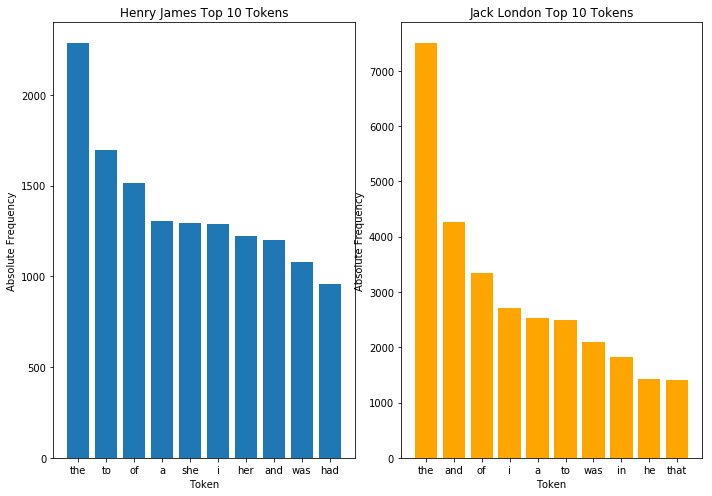

In [48]:
plt.subplot(1,2,1)
plt.bar(range(1,11),top_james_vals)
plt.tight_layout()
plt.xticks(range(1,11),top_james_keys)
plt.xlabel('Token')
plt.ylabel('Absolute Frequency')
plt.title('Henry James Top 10 Tokens')
plt.subplot(1,2,2)
plt.bar(range(1,11),top_london_vals,color='orange')
plt.tight_layout()
plt.xticks(range(1,11),top_london_keys)
plt.xlabel('Token')
plt.ylabel('Absolute Frequency')
plt.title('Jack London Top 10 Tokens')
plt.show()

In [49]:
V_james = len(james_counts)
N_james = sum(list(james_counts.values()))

V_london = len(london_counts)
N_london = sum(list(london_counts.values()))

In [50]:
vocab_train = (set(list(james_counts.keys())+list(london_counts.keys())))
print((V_james))
print((V_london))
print(len(vocab_train))
V_train = len(vocab_train)

6206
11153
14086


In [51]:
def generate_probs(train_1,smooth=False,alpha=0.0,N=None,V=None):
    #vocabs = []
    probs_1 = {}
    assert N is not None
    if smooth:
        assert V is not None
    for word in vocab_train:
        if word in train_1:
    #for word in train_1:
            if not smooth:
                #probs_1 = {k:v/N for k,v in train_1.items()}
                probs_1[word] = train_1[word] / N
            else:
                probs_1[word] = (train_1[word] + alpha) / (N + alpha * V)
        else:
            if not smooth:
            #probs_1 = {k:v/N for k,v in train_1.items()}
                probs_1[word] = 0.0
            else:
                probs_1[word] = (0.0 + alpha) / (N + alpha * V)
    return probs_1

In [52]:
alpha=0.1
james_prob = generate_probs(james_counts,smooth=True,alpha=alpha,N=N_james,V=V_train)
london_prob = generate_probs(london_counts,smooth=True,alpha=alpha,N=N_london,V=V_train)
train_probs = [james_prob,london_prob]

In [53]:
D_james = len(os.listdir(os.path.join(corpus_path,auth1)))
D_london = len(os.listdir(os.path.join(corpus_path,auth2)))
P_classes = []
P_classes.append(D_james / (D_james + D_london))
P_classes.append(D_london / (D_james + D_london))
unk_prob = []
# unk_prob.append((0.0 + alpha) / (N_james + alpha * V_james))
# unk_prob.append((0.0 + alpha) / (N_london + alpha * V_london))
unk_prob.append((0.0 + alpha) / (N_james + alpha * V_train))
unk_prob.append((0.0 + alpha) / (N_london + alpha * V_train))

In [54]:
test_dir = 'test'
directory = os.path.join(corpus_path,test_dir)
test_files = os.listdir(directory)
test_texts = []
for file in test_files:
    test_texts.append(normalize_text(os.path.join(directory,file)))
print(len(test_texts))

Reading file: corpus/test\test1.txt
Reading file: corpus/test\test2.txt
Reading file: corpus/test\test3.txt
3


In [55]:
test_text = [x.split() for x in test_texts]

In [58]:
'''
Naive Bayes Classifier
0 --> Author1 i.e. Henry James
1 --> Author2 i.e. Jack London
'''
preds = []
for text in test_text:
    #vocab_test = list(set(text))
    vocab_test = text
    #print("Test vocab size:",len(vocab_test))
    prob_class = []
    '''
    Compute log probabilities. Then max_prob = max_log(prob)
    '''
    for i in range(len(P_classes)):
        log_prob = math.log(P_classes[i])
        for token in vocab_test:
            if token in train_probs[i]:
                #print("Here")
                log_prob += math.log(train_probs[i][token])
            else:
                log_prob += math.log(unk_prob[i])
        prob_class.append(log_prob)
    #print("Probs:",prob_class)
    preds.append(prob_class.index(max(prob_class)))

'''
Now print the predictions
'''
for i in range(len(test_files)):
    if preds[i] == 0:
        pred = "Henry James"
    else:
        pred = "Jack London"
    print("Predicted author of document \""+test_files[i]+"\" is "+pred)
#print(preds)

Predicted author of document "test1.txt" is Henry James
Predicted author of document "test2.txt" is Jack London
Predicted author of document "test3.txt" is Jack London
